In [1]:
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader

In [2]:
directory='E:\CV\lab/BraTS2020_training_data/content/data/'
l=os.listdir(directory)
h5_files=[f for f in l if f.endswith('.h5')]
print('Found:',len(h5_files),'Example files:',h5_files[:3])

Found: 57195 Example files: ['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']


In [3]:
if h5_files:
    fp=os.path.join(directory,h5_files[25070])
    with h5py.File(fp,'r') as f:
        for key in f.keys():
            print('Keys for each file:',list(f.keys()))
            print('Shape:',f[key].shape)
            print('Array dtype:',f[key].dtype)
            print('Max:',np.max(f[key]))
            print('Min:',np.min(f[key]))

Keys for each file: ['image', 'mask']
Shape: (240, 240, 4)
Array dtype: float64
Max: 4.755863264388587
Min: -0.5070322108800785
Keys for each file: ['image', 'mask']
Shape: (240, 240, 3)
Array dtype: uint8
Max: 1
Min: 0


In [4]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(8,8))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()

In [5]:
data = {}
with h5py.File(fp, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

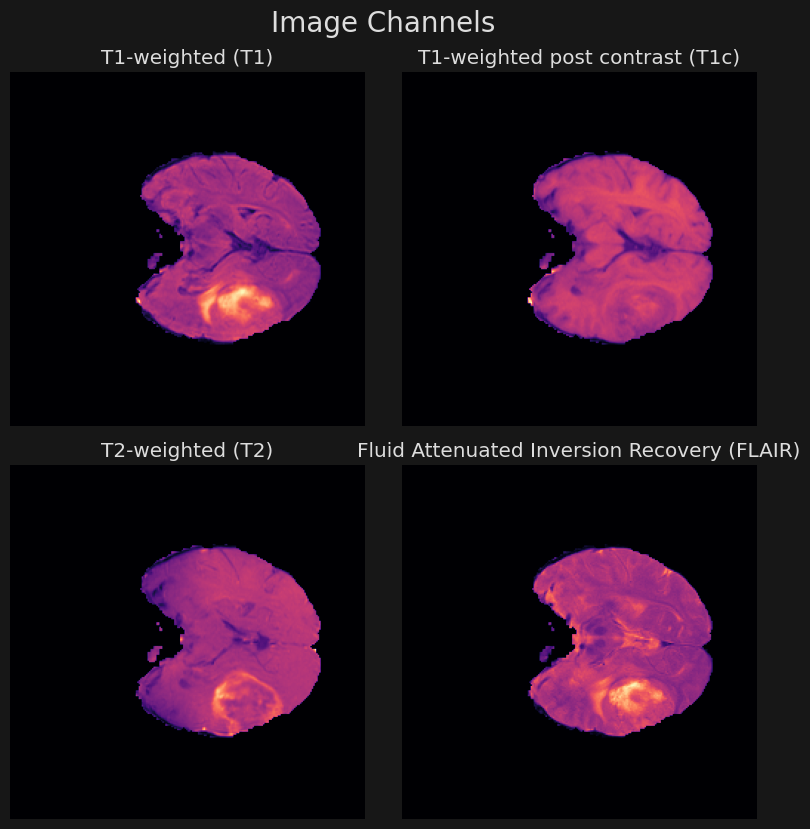

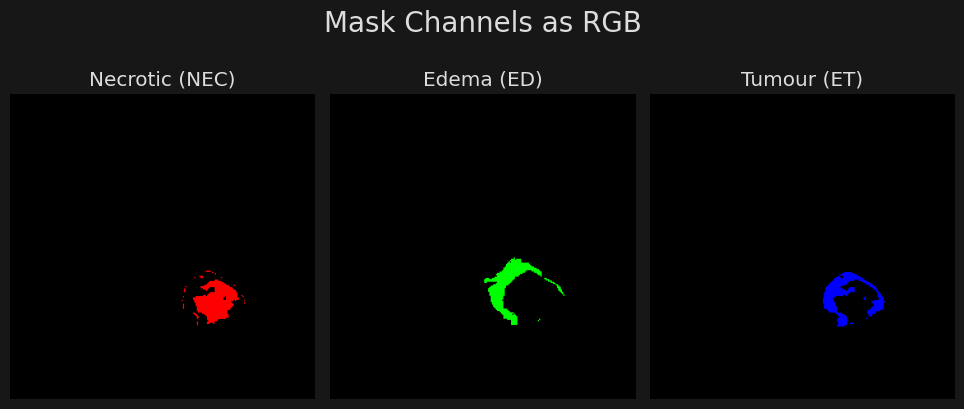

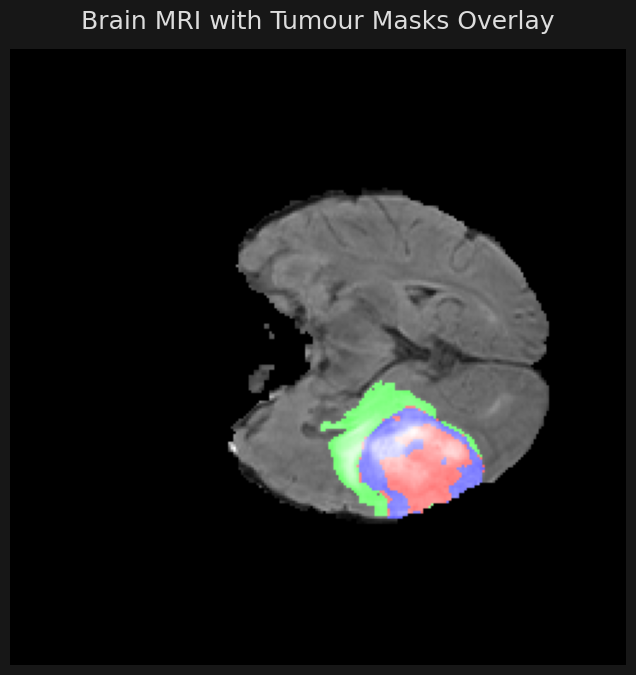

In [6]:
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


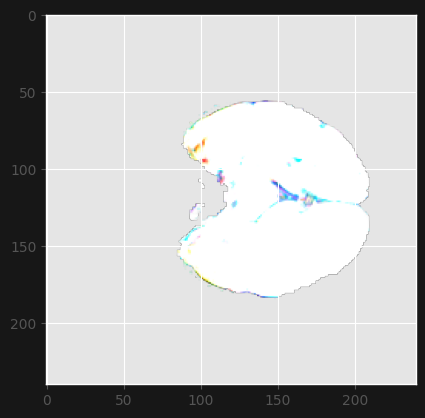

In [7]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'
plt.imshow(data['image'])

In [8]:
len(data)

2

In [9]:
class Brainscan(Dataset):
    def __init__(self,file_paths,deterministic=False):
        self.file_paths=file_paths
        if deterministic:
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self,idx):
        file_path=self.file_paths[idx]
        directory='E:/College/3rd year/Sem 6/Image and Video Processing/Lab/Image segmentation/BraTS2020_training_data/content/data/'
        fp=os.path.join(directory,file_path)
        #print(fp)
        with h5py.File(fp,'r') as f:
            img=f['image'][()]
            mask=f['mask'][()]
            img=img.transpose((2,0,1))
            mask=mask.transpose((2,0,1))
            for i in range(img.shape[0]):
                min_val=np.min(img[i])
                img[i]=img[i]-min_val
                max_val=np.max(img[i])+1e-4
                img[i]=img[i]/max_val
            img=torch.tensor(img,dtype=torch.float32)
            mask=torch.tensor(mask,dtype=torch.float32)
        return img,mask

In [15]:
directory='E:/College/3rd year/Sem 6/Image and Video Processing/Lab/Image segmentation/BraTS2020_training_data/content/data/'
l=os.listdir(directory)
h5_files=[f for f in l if f.endswith('.h5')]

np.random.seed(42)
np.random.shuffle(h5_files)

split_idx=int(0.9*len(h5_files))
train_files=h5_files[:split_idx]
val_files=h5_files[split_idx:]

train_dataset=Brainscan(train_files)
val_dataset=Brainscan(val_files,deterministic=True)

train_dataloader=DataLoader(train_dataset,batch_size=5,shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=5,shuffle=True)

test_input_iter=iter(DataLoader(val_dataset,batch_size=1,shuffle=False))

for images,masks in train_dataloader:
    print('Training batch-Image shape:',images.shape,'Mask shape:',masks.shape)
    break

for images,masks in val_dataloader:
    print('Validation batch-Image shape:',images.shape,'Maks shape:',masks.shape)
    break
    

Training batch-Image shape: torch.Size([5, 4, 240, 240]) Mask shape: torch.Size([5, 3, 240, 240])
Validation batch-Image shape: torch.Size([5, 4, 240, 240]) Maks shape: torch.Size([5, 3, 240, 240])


In [16]:
from torch import nn

class Encoder(nn.Module):
    def __init__(self,in_channels,out_channels,activation=nn.ReLU()):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=(3,3),stride=1,padding=1),
            activation,
            nn.Conv2d(out_channels,out_channels,kernel_size=(3,3),stride=1,padding=1),
            activation
        )
    def forward(self,x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self,in_channels,out_channels,activation=nn.ReLU()):
        super().__init__()
        self.decoder=nn.Sequential(
            nn.Conv2d(in_channels,in_channels//2,kernel_size=(3,3),stride=1,padding=1),
            activation,
            nn.Conv2d(in_channels//2,out_channels,kernel_size=(3,3),stride=1,padding=1),
            activation
        )
    def forward(self,x):
        return self.decoder(x)


class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        in_channels=4
        out_channels=3
        n_filters=32
        activation=nn.ReLU()

        self.downsample=nn.MaxPool2d((2,2),stride=2)
        self.upsample=nn.UpsamplingBilinear2d(scale_factor=2)

        self.enc1=Encoder(in_channels,1*n_filters,activation)
        self.enc2=Encoder(1*n_filters,2*n_filters,activation)
        self.enc3=Encoder(2*n_filters,4*n_filters,activation)
        self.enc4=Encoder(4*n_filters,8*n_filters,activation)

        self.bottleneck=nn.Sequential(
            nn.Conv2d(8*n_filters,16*n_filters,kernel_size=(3,3),stride=1,padding=1),
            activation,
            nn.Conv2d(16*n_filters,8*n_filters,kernel_size=(3,3),stride=1,padding=1),
            activation
        )
        self.dec4=Decoder(16*n_filters,4*n_filters,activation)
        self.dec3=Decoder(8*n_filters,2*n_filters,activation)
        self.dec2=Decoder(4*n_filters,1*n_filters,activation)
        self.dec1=Decoder(2*n_filters,1*n_filters,activation)

        self.output=nn.Conv2d(1*n_filters,out_channels,kernel_size=(1,1),stride=1,padding=0)

    def forward(self,x):

        skip1=self.enc1(x)
        x=self.downsample(skip1)
        skip2=self.enc2(x)
        x=self.downsample(skip2)
        skip3=self.enc3(x)
        x=self.downsample(skip3)
        skip4=self.enc4(x)
        x=self.downsample(skip4)

        x=self.bottleneck(x)

        x=self.upsample(x)
        x=torch.cat((x,skip4),axis=1)
        x=self.dec4(x)
        x=self.upsample(x)
        x=torch.cat((x,skip3),axis=1)
        x=self.dec3(x)
        x=self.upsample(x)
        x=torch.cat((x,skip2),axis=1)
        x=self.dec2(x)
        x=self.upsample(x)
        x=torch.cat((x,skip1),axis=1)
        x=self.dec1(x)
        x=self.output(x)
        return x

def count_param(model):
    tot=sum(p.numel() for p in model.parameters())
    print('Total parameters:',tot)

def save(model,path='model_weights.pth'):
    torch.save(model.state_dict(),path)
        

In [27]:
def train(model,train_dataloader,val_dataloader,config,verbose=True):
    device=config['device']
    n_epochs=config['n_epochs']
    learning_rate=config['learning_rate']
    batches_per_epoch=config['batches_per_epoch']
    lr_decay_factor=config['lr_decay_factor']

    model.to(device)
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
    loss_fn=nn.BCEWithLogitsLoss()

    train_epoch_losses=[]
    val_epoch_losses=[]

    for epoch in range(1,n_epochs+1):
        current_lr=learning_rate*(lr_decay_factor**(epoch-1))
        for param_grp in optimizer.param_groups:
            param_grp['lr']=current_lr
        model.train()
        train_epoch_loss=0
        for train_batch_idx,(train_inp,train_tar) in enumerate(train_dataloader,start=1):
            if verbose:
                print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inp=train_inp.to(device)
            train_tar=train_tar.to(device)
            train_pred=model(train_inp)
            train_batch_loss=loss_fn(train_pred,train_tar)
            train_epoch_loss+=train_batch_loss.item()
            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx>=batches_per_epoch:
                if verbose: print()
                break
        train_epoch_losses.append(train_epoch_loss)
    model.eval()
    val_epoch_loss=0
    with torch.no_grad():
        for val_batch_idx,(val_inp,val_tar) in enumerate(val_dataloader,start=1):
            if verbose:
                print(f"\rValidation batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/train_batch_idx:.6f}", end='')
            val_inp=val_inp.to(device)
            val_tar=val_tar.to(device)
            val_pred=model(val_inp)
            val_batch_loss=loss_fn(val_pred,val_tar)
            val_epoch_loss+=val_batch_loss.item()

            if val_batch_idx>=batches_per_epoch:
                if verbose: print()
                break
            val_epoch_losses.append(val_epoch_loss)
    if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")
    return train_epoch_losses,val_epoch_losses

In [28]:
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          10,
    'batch_size':        32,
    'learning_rate':     1e-3,
    'batches_per_epoch': 50,
    'lr_decay_factor':   1
}


model=UNet()
count_param(model)

train_dataloader=DataLoader(train_dataset,batch_size=train_config['batch_size'],shuffle=True)
val_dataloader=DataLoader(val_dataset,batch_size=train_config['batch_size'],shuffle=True)


Total parameters: 5496451


In [29]:
train_epoch_losses,val_epoch_losses=train(model,train_dataloader,val_dataloader,train_config,verbose=True)

Train batch: 50/50, Avg batch loss: 0.106225
Train batch: 50/50, Avg batch loss: 0.018124
Train batch: 50/50, Avg batch loss: 0.015687
Train batch: 50/50, Avg batch loss: 0.014032
Train batch: 50/50, Avg batch loss: 0.012631
Train batch: 50/50, Avg batch loss: 0.011037
Train batch: 50/50, Avg batch loss: 0.010469
Train batch: 50/50, Avg batch loss: 0.009323
Train batch: 50/50, Avg batch loss: 0.009478
Train batch: 50/50, Avg batch loss: 0.009815
Validation batch: 50/50, Avg batch loss: 0.008420
Epoch: 10, Train loss: 0.495907, Val loss: 0.429618, lr 0.001000



In [35]:
len(val_epoch_losses),len(train_epoch_losses)

(49, 10)

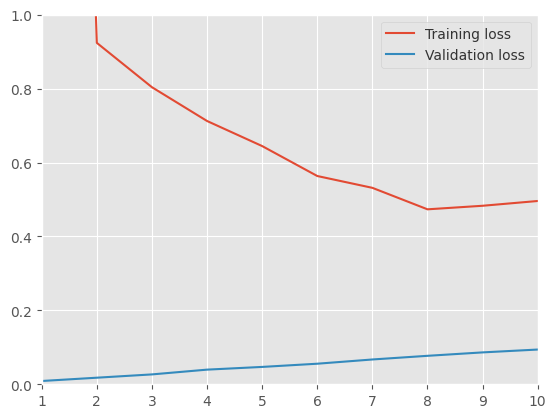

In [38]:
plt.plot([np.NaN]+train_epoch_losses,label='Training loss')
plt.plot([np.NaN]+val_epoch_losses,label='Validation loss')
plt.ylim(0, 1)
plt.xlim(1,10)
plt.legend()
plt.show()

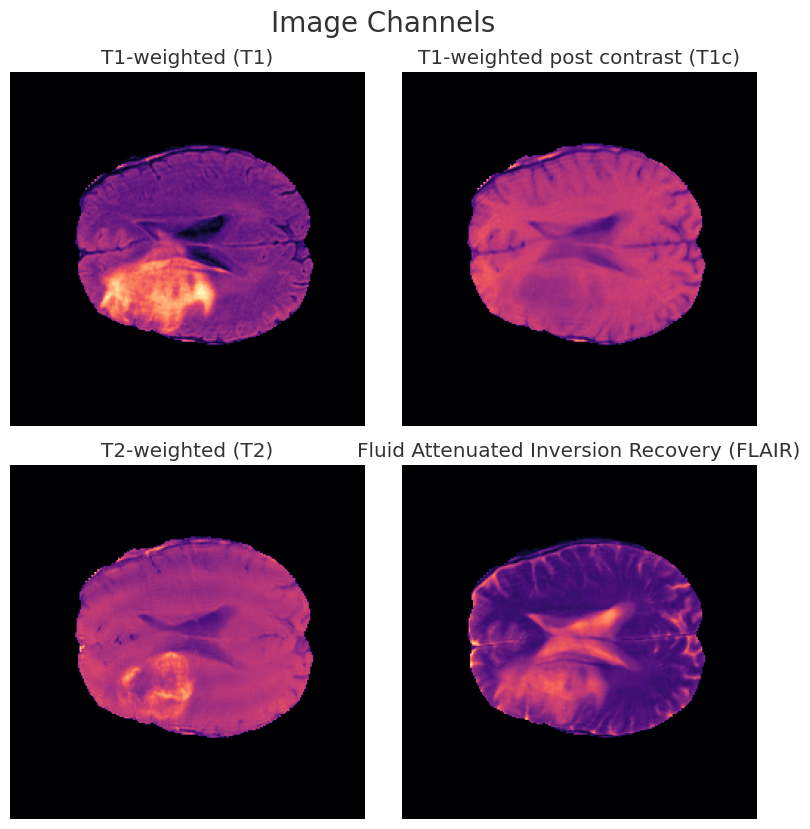

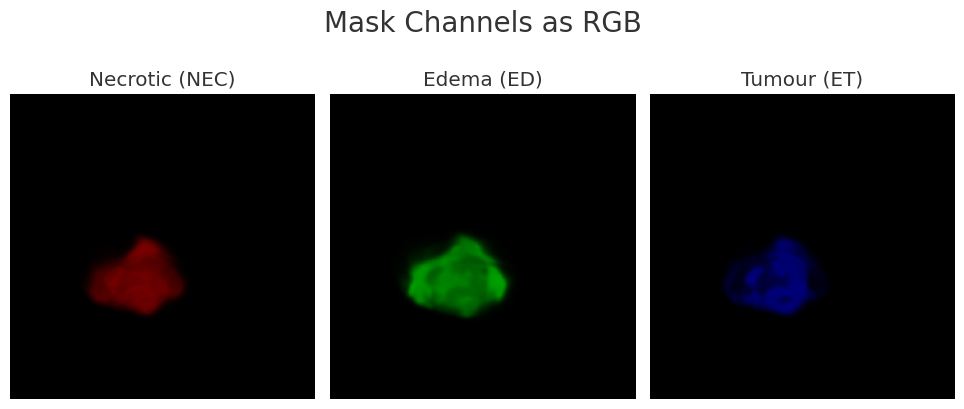

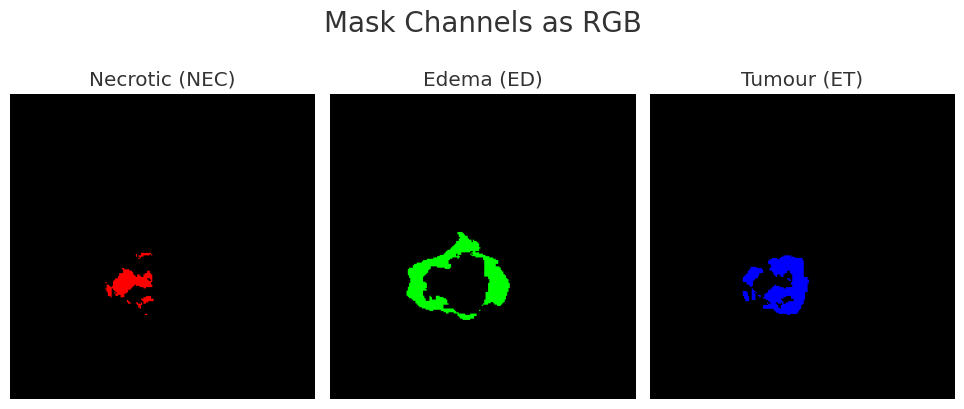

In [39]:
def test(model,test_inp,test_tar,device):
    test_inp,test_tar=test_inp.to(device),test_tar.to(device)
    test_pred=torch.sigmoid(model(test_inp))

    image=test_inp.detach().cpu().numpy().squeeze(0)
    mask_pred=test_pred.detach().cpu().numpy().squeeze(0)
    mask_target=test_tar.detach().cpu().numpy().squeeze(0)

    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred)
    display_mask_channels_as_rgb(mask_target)

device='cuda'
test_inp,test_tar=next(test_input_iter)
test(model,test_inp,test_tar,device)